<a href="https://colab.research.google.com/github/abrarelidrisi/MRI-Segmentation/blob/main/Trial_4_CCL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing important libraries and loading our dataset (containing of MRI scans and the ground truth (Segmented)images
from scipy.io import loadmat
import sys
import matplotlib.pyplot as plt
import imageio
import scipy.ndimage as ndi
import numpy as np
from skimage import data
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage.morphology import remove_small_objects, remove_small_holes, binary_dilation
from sklearn.cluster import KMeans



data = loadmat('Brain.mat')
T1= data['T1']
label= data['label']

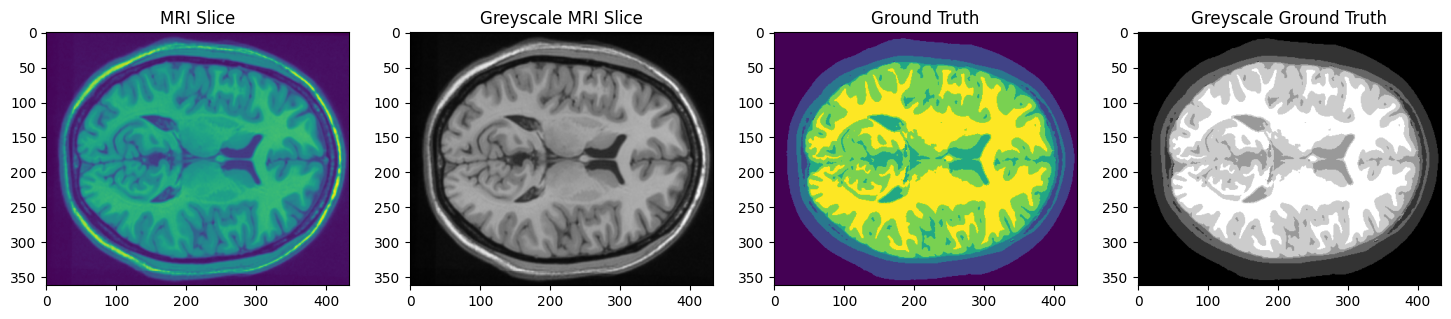

In [2]:
#Choose any slice idx here, we will showcase it and its ground truth, visualizing their greyscale versions as well
slice_idx = 8

mri_slice = T1[..., slice_idx]
ground_truth = label[..., slice_idx ]


fig, axes = plt.subplots(1,4, figsize=(18, 6))
ax = axes.ravel()
ax[0].imshow(mri_slice)
ax[0].set_title("MRI Slice")
ax[1].imshow(mri_slice, cmap= "grey")
ax[1].set_title("Greyscale MRI Slice")
ax[2].imshow(ground_truth)
ax[2].set_title("Ground Truth")
ax[3].imshow(ground_truth, cmap="grey")
ax[3].set_title("Greyscale Ground Truth")
plt.show()

In [3]:
#Check the range of intensities for our two images
print(f"Range of mri scan intensities: {np.max(mri_slice) - np.min(mri_slice)}")
print(f"Range of ground truth intensities: {np.max(ground_truth) - np.min(ground_truth)}")

Range of mri scan intensities: 469219.4375
Range of ground truth intensities: 5


In [4]:
#Since I'll be using edge detection algorithms like Canny later on, It's better to normalize our data so the algorithms can perform better and not put muc count to outliers
T1_normalized = (T1 - np.min(T1)) / (np.max(T1) - np.min(T1))
T1_normalized = (T1_normalized * 255)
print(f"Range of mri scan intensities upon normalizing: {np.max(T1_normalized) - np.min(T1_normalized)}")

mri_normalized = T1_normalized[...,slice_idx]

Range of mri scan intensities upon normalizing: 255.0


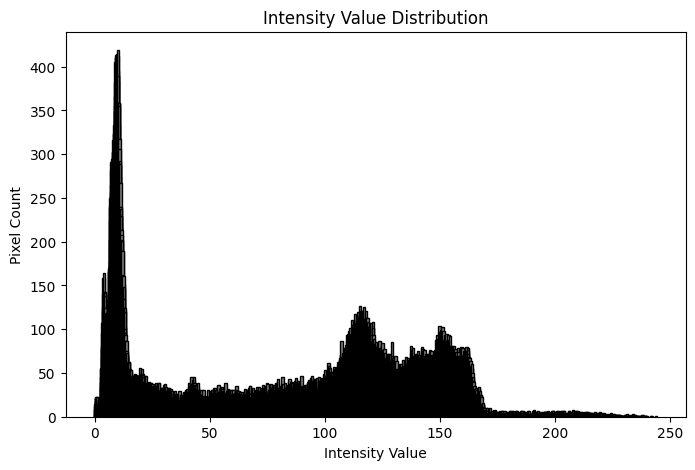

In [5]:
def show_intensity_values(image):
    # Get unique intensity values and their counts
    unique_values, counts = np.unique(image, return_counts=True)

    # Plot a histogram to visualize the intensity distribution
    plt.figure(figsize=(8, 5))
    plt.bar(unique_values, counts, color='gray', edgecolor='black', width=1)
    plt.title("Intensity Value Distribution")
    plt.xlabel("Intensity Value")
    plt.ylabel("Pixel Count")
    plt.show()
show_intensity_values(mri_normalized)

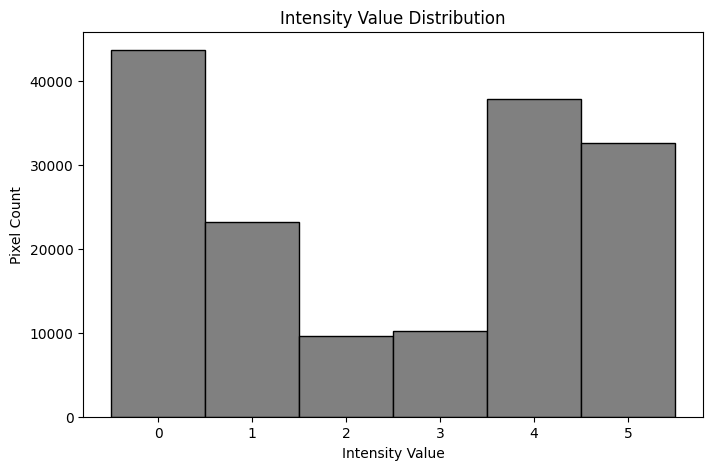

In [6]:
# Plot a histogram to visualize the intensity distribution
show_intensity_values(ground_truth)

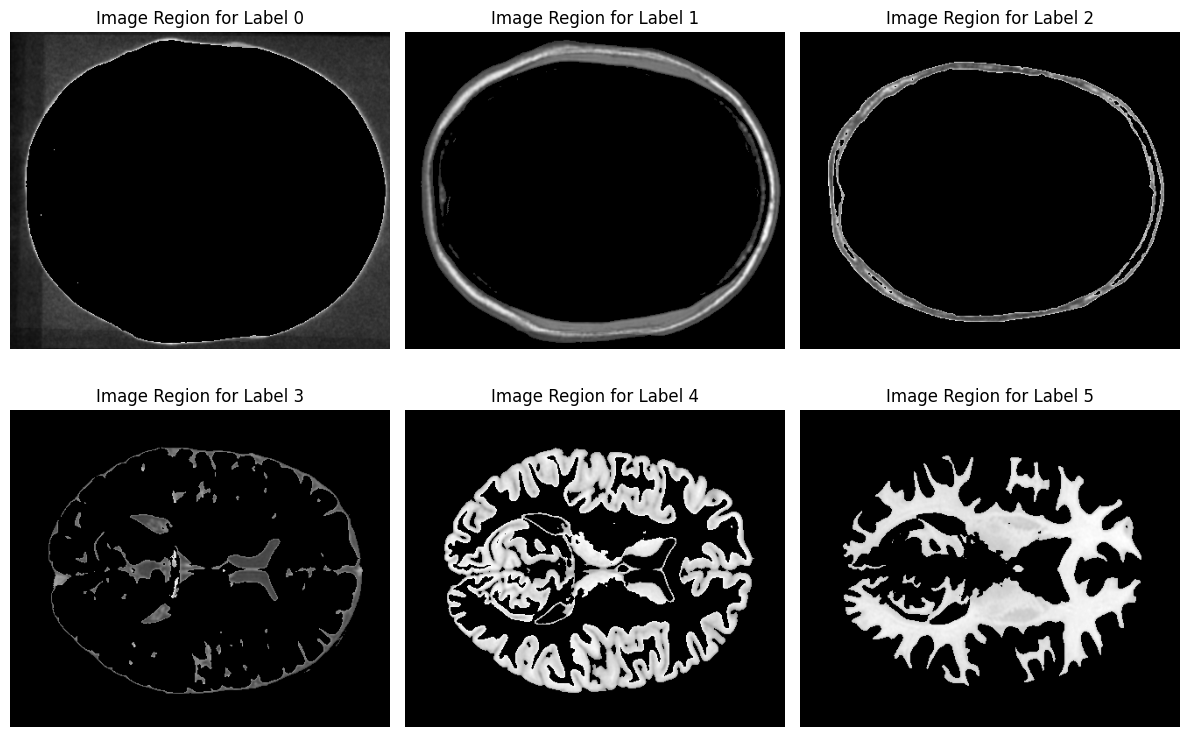

In [7]:
#Visualizing the image regions for each label in the original image
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    mask = mri_normalized*(ground_truth == i)
    ax.imshow(mask.reshape(mri_normalized.shape), cmap='gray')
    ax.set_title(f'Image Region for Label {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

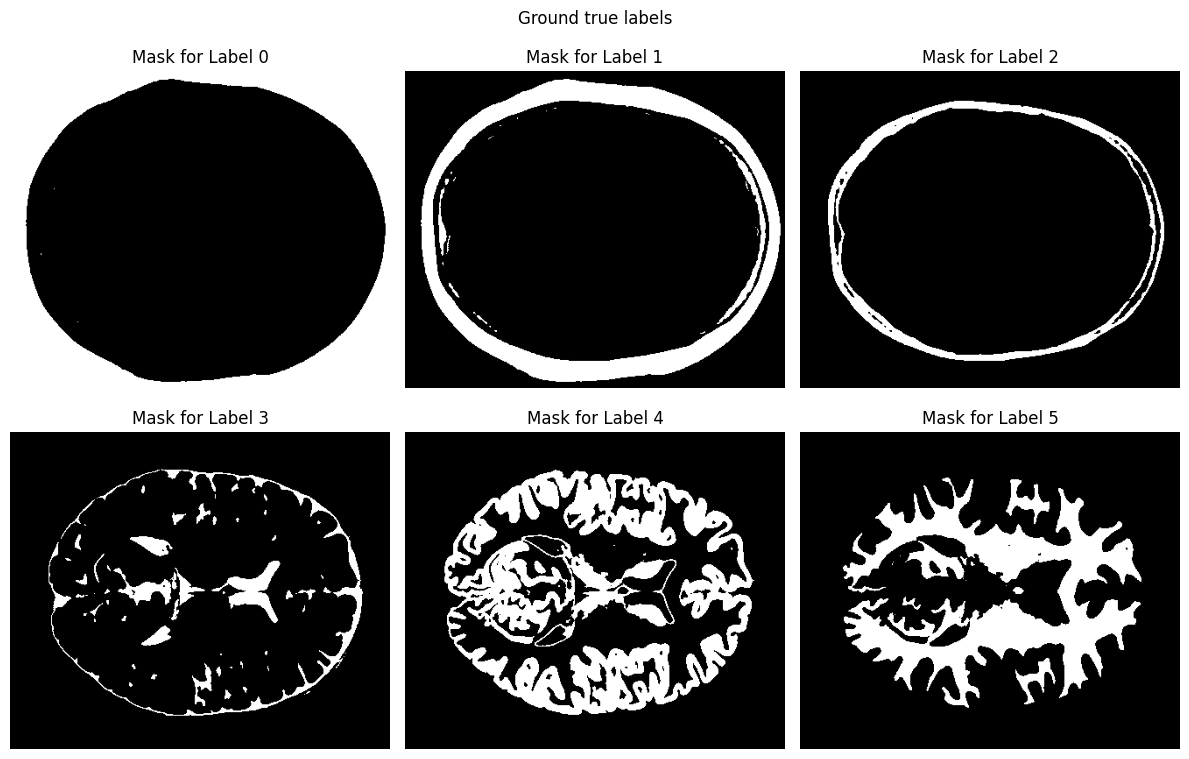

In [8]:
#Visualizing the labels in the ground truth image
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(ground_truth == i, cmap='gray')
    ax.set_title(f'Mask for Label {i}')
    ax.axis('off')

plt.suptitle("Ground true labels")
plt.tight_layout()
plt.show()

In [9]:
#Creating a dictionary called temporal_mask to ensure correct mapping of labels, defining two functions for plotting images as well as combining the masks for the final segmented image
temporal_masks = {}

def plot_masks(temporal_masks, rows=1, cols=2, slice_id = None):

    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

    fig.suptitle('Temporal Masks')

    flatten_axes = axes.flat
    for ax, (key, mask) in zip(flatten_axes, temporal_masks.items()):
        if slice_id is not None:
            mask = mask[:,:,slice_id]
        ax.imshow(mask, cmap='gray')
        ax.set_title(f'Mask: {key}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def temporal_masks2final_segmented_mask(temporal_masks, labels = range(6), slice_id = None):
    if slice_id is not None:
        segmented_labels = np.zeros_like(temporal_masks["0"][:,:,0])
    else:
        segmented_labels = np.zeros_like(temporal_masks["0"])

    # Accumulate all the temporal masks in the segmented_labels
    for label in labels:
        mask = temporal_masks[str(label)]
        if slice_id is not None:
            mask = mask[:,:,slice_id]
        segmented_labels[mask == 1] = label

    return segmented_labels

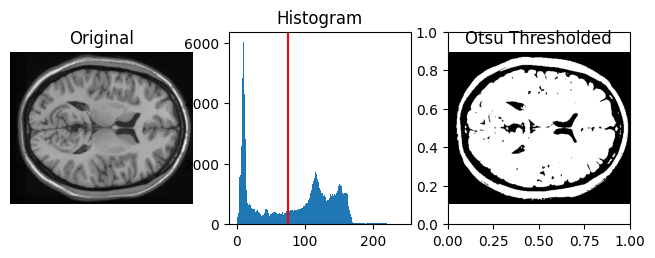

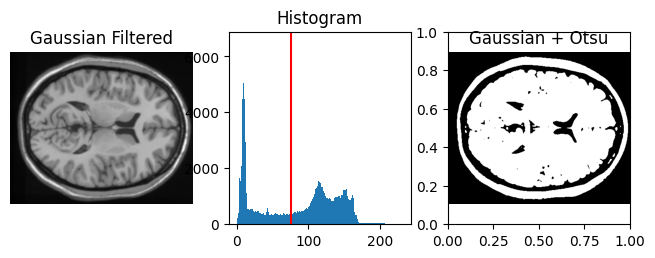

In [10]:
#My first goal is to segment the image into background and foreground (the tissue). For this, I apply Otsu threshold
def gaussian_otsu(image):
  thresh = threshold_otsu(image)
  binary = image > thresh

  #We plot the original images, their histograms and then their Otsu thresholded results
  fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
  ax = axes.ravel()
  ax[0] = plt.subplot(1, 3, 1)
  ax[1] = plt.subplot(1, 3, 2)
  ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

  ax[0].imshow(image, cmap="grey")
  ax[0].set_title('Original')
  ax[0].axis('off')

  ax[1].hist(image.ravel(), bins=256)
  ax[1].set_title('Histogram')
  ax[1].axvline(thresh, color='r')

  ax[2].imshow(binary, cmap="grey")
  ax[2].set_title('Otsu Thresholded')
  ax[2].axis('off')


  #We try using a gaussian filter (for blurring) before Otsu threshold and see the difference between the two
  gaussian_image = gaussian(image, sigma=1)
  binary_gaussian = gaussian_image > thresh


  #We plot the gaussian filtered images, their histograms and then their Otsu thresholded results
  fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
  ax = axes.ravel()
  ax[0] = plt.subplot(1, 3, 1)
  ax[1] = plt.subplot(1, 3, 2)
  ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

  ax[0].imshow(gaussian_image, cmap="grey")
  ax[0].set_title('Gaussian Filtered')
  ax[0].axis('off')

  ax[1].hist(gaussian_image.ravel(), bins=256)
  ax[1].set_title('Histogram')
  ax[1].axvline(thresh, color='r')

  ax[2].imshow(binary_gaussian, cmap="grey")
  ax[2].set_title('Gaussian + Otsu')
  ax[2].axis('off')

  plt.show()
  return binary_gaussian
binary_gaussian = gaussian_otsu(mri_normalized)

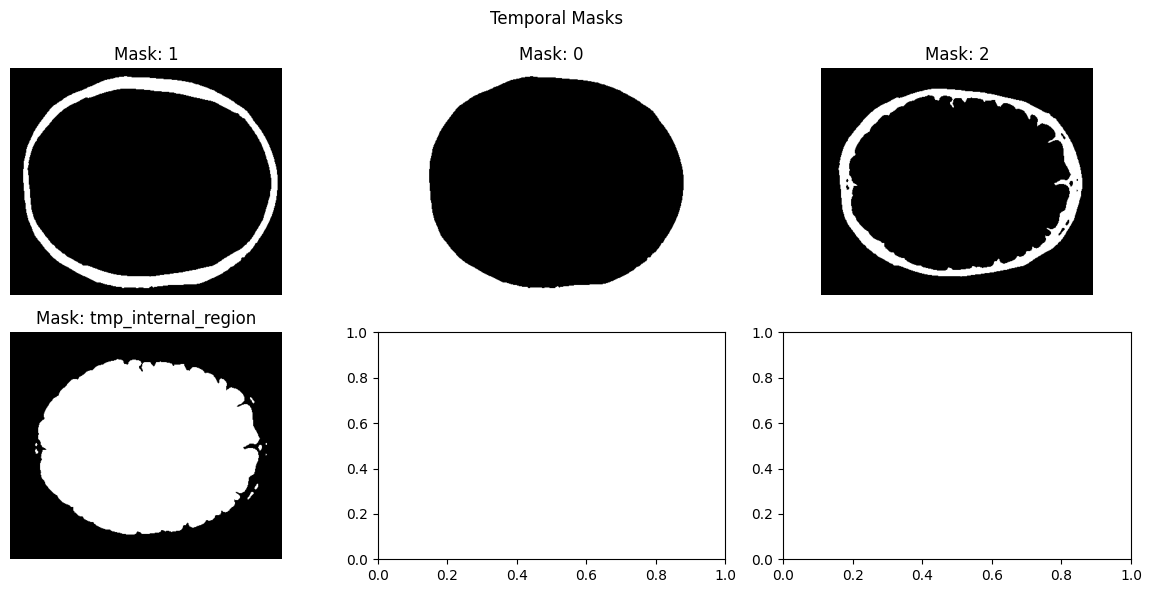

In [11]:
# Apply the CCL algorithm to the cleaned image to have preliminary labels
def getting_masks(binary_gaussian):
  labels, num_labels = ndi.label(binary_gaussian)
  #Mask 1 here represents label 1 (skin)
  temporal_masks["1"] = (labels == 1).astype(int)

  #We invert the image to get to labeling the other parts
  inverted = ~binary_gaussian
  # using the same two-pass algorithm
  inverted_labels, num_labels = ndi.label(inverted)

  # Only consider the two first labels and all the other to zero
  inverted_labels[inverted_labels > 2] = 0

  # Save temporal masks label 0 and 2
  temporal_masks["0"] = (inverted_labels == 1).astype(int)
  temporal_masks["2"] = (inverted_labels == 2).astype(int)

  # Got the tmp internal region by considering all that is not part of the mask 0, 1, 2
  tmp_mask = temporal_masks["0"] + temporal_masks["1"] + temporal_masks["2"]
  temporal_masks["tmp_internal_region"] = (tmp_mask == 0).astype(int)

  # Plot temporal masks
  plot_masks(temporal_masks, rows=2, cols=3)
  return temporal_masks

temporal_masks = getting_masks(binary_gaussian)

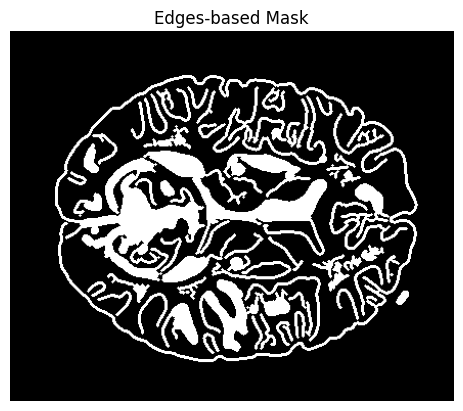

In [12]:
def applying_canny(mri_normalized):
  #Apply canny detector so we can accurately detect and segment the edges within the internal structure
  masked_internal = mri_normalized * (temporal_masks["tmp_internal_region"])


  edges = canny(masked_internal, sigma=2)
  # Dilate the edges
  edges = ndi.binary_dilation(edges)

  # Fill holes in the edges
  edges = ndi.binary_fill_holes(edges)

  # remove small objects
  edges = remove_small_objects(edges, min_size=100)
  # Plot the edges
  plt.imshow(edges, cmap='gray')
  plt.axis('off')
  plt.title('Edges-based Mask')
  plt.show()
  return edges

edges = applying_canny(mri_normalized)


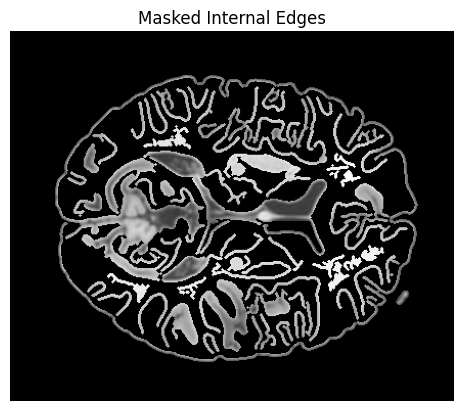

In [13]:
def internal_region():
  # Get the internal region of the reference image using the mask and showcase the result
  masked_internal_region = mri_normalized * edges
  plt.imshow(masked_internal_region , cmap='gray')
  plt.axis('off')
  plt.title('Masked Internal Edges')
  plt.show()
  return masked_internal_region

masked_internal_region = internal_region()

In [14]:
#Define k-means segmentation so we can apply it to the intenal structure
def kmeans_segmentation(image, n_clusters=4):
    # Reshape the image to a 2D array
    X = image.reshape(-1, 1)

    # Fit KMeans to the data
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

    # Predict the labels for the data
    labels = kmeans.predict(X)

    # Reshape the labels to the original image shape
    labels = labels.reshape(image.shape)

    # Get the centroids of the clusters
    centroids = kmeans.cluster_centers_

    # Order the centroids and return the indices
    order = np.argsort(centroids, axis=0)

    return labels, order


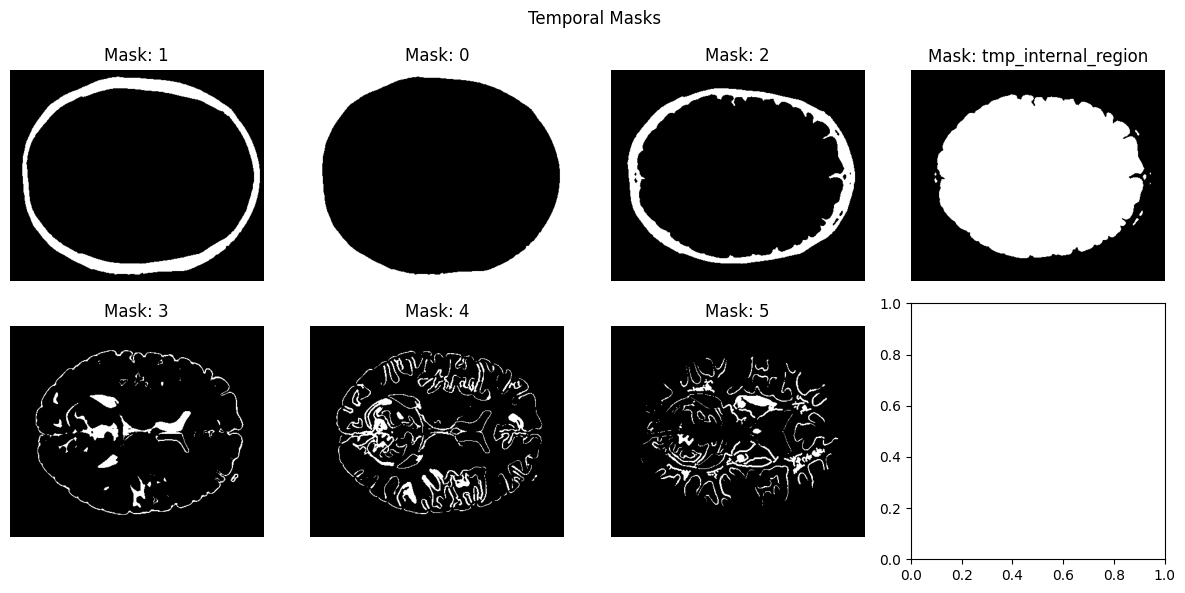

In [15]:
def rest_of_masks():
  # Apply k-means clustering to the partial_reference image
  internal_labels, order = kmeans_segmentation(masked_internal_region, n_clusters=4)

  # Use the order to fit the mask 3, 4, 5
  temporal_masks["3"] = (internal_labels == order[1]).astype(int)
  temporal_masks["4"] = (internal_labels == order[2]).astype(int)
  temporal_masks["5"] = (internal_labels == order[3]).astype(int)

  # Plot temporal masks
  plot_masks(temporal_masks, rows=2, cols=4)
  return temporal_masks

temporal_masks = rest_of_masks()

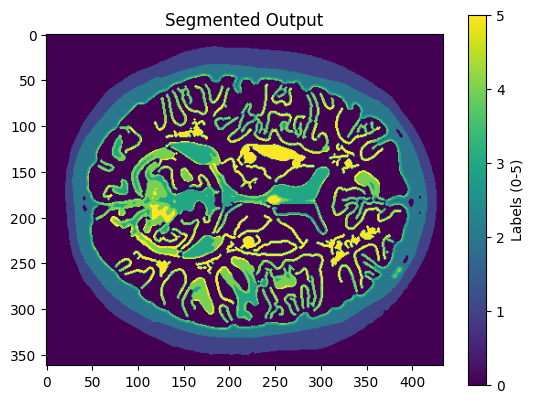

In [16]:
segmented_img = temporal_masks2final_segmented_mask(temporal_masks)

# Plot the final segmented image
plt.imshow(segmented_img)
plt.title('Segmented Output')
plt.colorbar(ticks=range(6), label="Labels (0-5)")
plt.show()

In [17]:
def dice_coefficient(pred, truth):
    pred = pred > 0  # Ensure binary format
    truth = truth > 0  # Ensure binary format
    intersection = np.sum(pred * truth)
    return 2 * intersection / (np.sum(pred) + np.sum(truth))

# Calculate Dice coefficient for final combination
dice_score = dice_coefficient(segmented_img, ground_truth)
print(f"Dice Coefficient for Final Combination: {dice_score:.3f}")

Dice Coefficient for Final Combination: 0.702


In [18]:
def jaccard_index(pred, truth):
    pred = pred > 0
    truth = truth > 0
    intersection = np.sum(pred * truth)
    union = np.sum(pred + truth) - intersection
    return intersection / union

# Calculate Jaccard Index
jaccard_score = jaccard_index(segmented_img, ground_truth)
print(f"Jaccard Index for Final Combination: {jaccard_score:.3f}")

Jaccard Index for Final Combination: 1.180


In [19]:
def pixel_accuracy(pred, truth):

    pred = pred > 0  # Ensure binary format
    truth = truth > 0  # Ensure binary format

    correct = np.sum(pred == truth)  # Count matching pixels
    total = truth.size  # Total number of pixels
    return correct / total

# Calculate accuracy for the final combined result
accuracy_score = pixel_accuracy(segmented_img, ground_truth)
print(f"Pixel Accuracy for Final Combination: {accuracy_score:.3f}")

Pixel Accuracy for Final Combination: 0.669


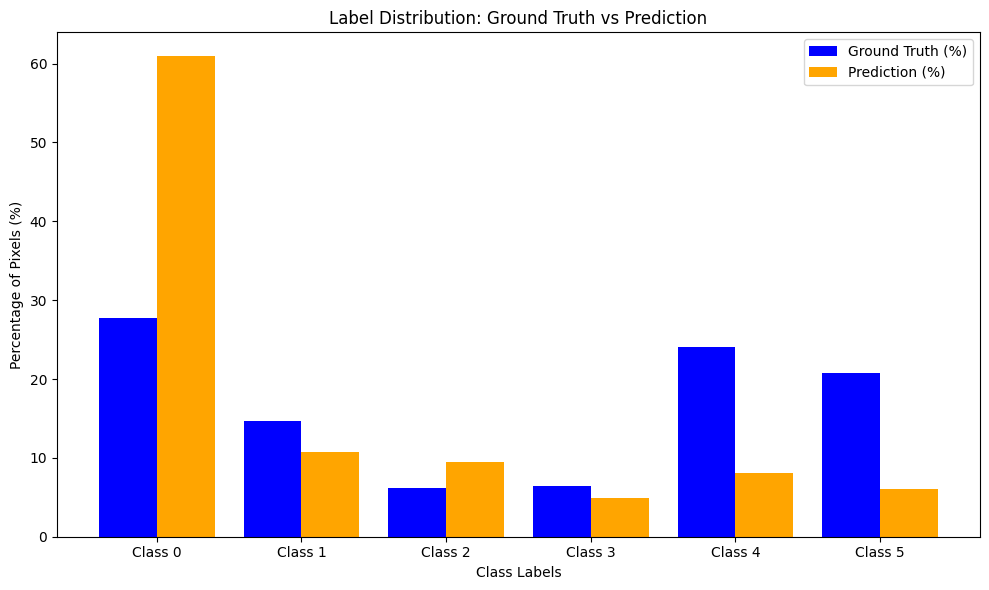

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def compare_label_distributions(ground_truth, prediction, num_classes):

    # Count label occurrences in ground truth
    gt_labels, gt_counts = np.unique(ground_truth, return_counts=True)
    gt_distribution = np.zeros(num_classes)
    gt_distribution[gt_labels] = gt_counts

    # Count label occurrences in prediction
    pred_labels, pred_counts = np.unique(prediction, return_counts=True)
    pred_distribution = np.zeros(num_classes)
    pred_distribution[pred_labels] = pred_counts

    # Normalize to percentage if needed
    gt_percentage = (gt_distribution / np.sum(gt_distribution)) * 100
    pred_percentage = (pred_distribution / np.sum(pred_distribution)) * 100

    # Plot the distributions
    labels = [f"Class {i}" for i in range(num_classes)]
    x = np.arange(num_classes)

    plt.figure(figsize=(10, 6))

    # Bar plot
    plt.bar(x - 0.2, gt_percentage, width=0.4, label='Ground Truth (%)', color='blue')
    plt.bar(x + 0.2, pred_percentage, width=0.4, label='Prediction (%)', color='orange')

    # Add labels, legend, and title
    plt.xticks(x, labels)
    plt.xlabel("Class Labels")
    plt.ylabel("Percentage of Pixels (%)")
    plt.title("Label Distribution: Ground Truth vs Prediction")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
num_classes = 6  # Number of classes in your dataset
compare_label_distributions(ground_truth, segmented_img, num_classes)